# I. Perkenalan


**Identity**

Wirawan Setio Aji <br>
BATCH-14 

**Dataset**

Dataset ini memiliki informasi tentang demografi pembayaran pinjaman credit. dimana melibatkan status **Debitur** dinyatakan gagal / berhasil membayar hutang dalam 1 semester terakhir<br>
data retrieved from BigQuery : [source](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default_next_moth&page=table)

```SELECT limit_balance, sex, education_level, marital_status, age, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, default_payment_next_month ```

``` FROM `bigquery-public-data.ml_datasets.credit_card_default` ```

`LIMIT 27916`


**Objective**<br>
membuat prediksi dengan target adalah `default_payment_next_month`  

**Conceptual Questions**
1. Apakah fungsi parameter `criterion` pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!
2. Apakah fungsi dari `pruning` pada Tree model?
3. Bagaimana cara memilih `K` yang optimal pada KNN?
4. Jelaskan apa yang kalian ketahui tentang `Cross Validation`!
5. Jelaskan apa yang kalian ketahui tentang `Accuracy, Precision, Recall, F1 Score`!


# II. Import Libraries

library yang digunakan saat mengerjakan project,

juga terdapat module **bikinan sendiri** untuk membantu handling outliers pada `outliermod`

In [1]:
import pandas as pd # Data flow
pd.set_option("display.max.columns",None) # display all columns
import numpy as np # algebra linear
%load_ext autoreload

%autoreload 2
# Data Visual
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Preprocessing
from sklearn.model_selection import train_test_split# split train test and train set
from sklearn.preprocessing import OrdinalEncoder  # feature encoding using ordinal encoder
from sklearn.preprocessing import MinMaxScaler # feature scalling MinMaxScaler

# Math Modelling
from sklearn.linear_model import LogisticRegression # Training Logistic Regression
from sklearn.svm import SVC # Training SVM classification
from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Naive Bayes model
from sklearn.ensemble import RandomForestClassifier # Random forest module
# !pip install xgboost 
from xgboost import XGBClassifier #xgboost Module use pip install above to install xgboost
# Evaluation Model 
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix # model evaluation using absolute error
from sklearn.model_selection import GridSearchCV,cross_val_score
 # outliers sencoring
from feature_engine.outliers import Winsorizer

from outliermod import skewness,outliersCheck,outlier_graph,censoring_outliers

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold


# III. Data Loading
Sebelum Melakukan **Data Explore**, muat data pada dataframe dan **mempelajari** secara umum tentang **tipe data**, **konteks setiap kolom** pada data yang diperoleh

In [2]:
# load Uber and lyft data into 'data' 
df_credit = pd.read_csv('./h8dsft_P1M1_wirawan_setio_aji.csv') # ,na_values=[' ?','?']
df_credit

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000.0,1,1,2,39.0,0.0,0.0,0.0,0.0,0,0,47174.0,47974.0,48630.0,50803.0,30789.0,15874.0,1800.0,2000.0,3000.0,2000.0,2000.0,2000.0,0
1,110000.0,2,1,2,29.0,0.0,0.0,0.0,0.0,0,0,48088.0,45980.0,44231.0,32489.0,26354.0,20221.0,2000.0,2010.0,3000.0,3000.0,3000.0,1000.0,0
2,270000.0,1,1,2,36.0,0.0,0.0,0.0,2.0,0,0,78630.0,68921.0,46512.0,40335.0,37165.0,22156.0,10076.0,4018.0,14.0,2051.0,2000.0,0.0,0
3,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
4,50000.0,1,1,2,24.0,0.0,0.0,0.0,0.0,0,0,42058.0,35340.0,22110.0,19837.0,19855.0,20151.0,1367.0,1606.0,692.0,709.0,721.0,692.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,210000.0,2,2,1,39.0,-1.0,-1.0,-1.0,-1.0,-2,-1,44100.0,0.0,28428.0,0.0,0.0,12000.0,0.0,28428.0,0.0,0.0,12000.0,33664.0,0
2961,280000.0,2,1,1,41.0,2.0,-1.0,-1.0,-1.0,-2,-1,280.0,6852.0,486.0,0.0,0.0,244.0,6859.0,486.0,0.0,0.0,244.0,0.0,0
2962,80000.0,1,1,2,28.0,1.0,-1.0,-1.0,-1.0,-2,-2,0.0,47.0,207.0,0.0,0.0,0.0,47.0,207.0,0.0,0.0,0.0,0.0,0
2963,200000.0,1,2,1,53.0,1.0,-1.0,-1.0,-2.0,-2,-1,0.0,2920.0,0.0,0.0,0.0,6753.0,2920.0,0.0,0.0,0.0,6753.0,0.0,1


In [3]:
# make copy backup
bak_income = df_credit.copy()


## Dataframe Info

jumlah baris,kolom dan tipe data

In [4]:
# shape of the dataframe
df_credit.shape

(2965, 24)

**Dataframe Shape** <br>
Data memiliki 2965 baris dan 24 kolom

- data hanya memiliki jenis data angka saja
- belum terlihat missing value sejauh ini

In [5]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   int64  
 10  pay_6                       2965 non-null   int64  
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

## Melihat lebih dalam tentang data Numerik dan Kategori

untuk mencari mana data yang sesungguhnya memiliki sifat **kategori** dengan melihat **rasio** antara jumlah ***unique value*** dan jumlah **barisnya**

In [6]:
length = len(df_credit)
list_col = list(df_credit.columns)
list_disc = []
def unique_ratio(df,col,length):
    return len(df[col].unique()) / length

for col in list_col:
    rate = unique_ratio(df_credit,col,length)
    if rate < 0.01:
        list_disc.append(col)
    print("unique ratio " + col +" :",rate)
    

unique ratio limit_balance : 0.019898819561551432
unique ratio sex : 0.0006745362563237774
unique ratio education_level : 0.002360876897133221
unique ratio marital_status : 0.0013490725126475548
unique ratio age : 0.016526138279932545
unique ratio pay_0 : 0.003709949409780776
unique ratio pay_2 : 0.003372681281618887
unique ratio pay_3 : 0.0030354131534569982
unique ratio pay_4 : 0.003372681281618887
unique ratio pay_5 : 0.0030354131534569982
unique ratio pay_6 : 0.0026981450252951096
unique ratio bill_amt_1 : 0.8913996627318719
unique ratio bill_amt_2 : 0.8741989881956155
unique ratio bill_amt_3 : 0.8596964586846543
unique ratio bill_amt_4 : 0.8445193929173693
unique ratio bill_amt_5 : 0.8370994940978077
unique ratio bill_amt_6 : 0.8300168634064081
unique ratio pay_amt_1 : 0.4772344013490725
unique ratio pay_amt_2 : 0.4627318718381113
unique ratio pay_amt_3 : 0.4391231028667791
unique ratio pay_amt_4 : 0.4094435075885329
unique ratio pay_amt_5 : 0.4026981450252951
unique ratio pay_amt

In [7]:
list_disc

['sex',
 'education_level',
 'marital_status',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'default_payment_next_month']

In [8]:
list_limit = list(df_credit['limit_balance'].unique())

Setelah melihat masing-masing rasio ***Unique Value*** pada setiap kolom, terdapat beberapa 
data numerik yang tergolong kategori yaitu pada kolom :

`'sex','education_level','marital_status','pay_0','pay_2'`
`,'pay_3','pay_4','pay_5','pay_6' 'default_payment_next_month'`

In [9]:
print(list_disc)
for col in list_disc:
    print(df_credit[col].unique())

['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default_payment_next_month']
[1 2]
[1 2 3 5 4 6 0]
[2 1 3 0]
[ 0. -1.  2.  1.  3. -2.  4.  5.  6.  7.  8.]
[ 0.  2. -2.  3.  4.  5.  6.  7.  1. -1.]
[ 0.  2. -1. -2.  3.  5.  6.  7.  4.]
[ 0.  2. -1.  3.  5. -2.  4.  6.  7.  8.]
[ 0  2  3  4 -1 -2  5  6  7]
[ 0  2 -2 -1  3  4  6  7]
[0 1]


### keterangan pada data katagori

- **Sex** : Gender (1=male, 2=female)
- **Education Level** : (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- **Marital status** (1=married, 2=single, 3=others)
- pada data `pay_0,pay_1,pay_3` dst, merupakan status pelunasan setiap bulan (-1=dibayar tepat, 1=tertunda 1 bulan month, 2=tertunda 2 bulan, ... 8=tertunda 8 bulan ,dst)
    - pay_0 bulan September
    - pay_2 bulan Agustus
    - pay_3 bulan Juli
    - pay_4 bulan Juni
    - pay_5 bulan May
    - pay_6 bulan April
- `'default_payment_next_month'`  merupakan target prediksi (1=yes, 0=no)

### Keterangan pada data numerik

- `limit_balance`  : merupakan batasan pada pelayanan kredit
- `bill_amt_` : jumlah tagihan bulanan
- `pay_amt_` : jumlah tagihan yang dibayar bulan lalu


## Menambah kolom
menambah kolom total untuk kolom menjumlah tiap baris pada kolom `pay_0`,`pay_2`,`pay_3`,`pay_4` ,dst
dan `pay_amt_1`,`pay_amt_2`,`pay_amt_3`,dst.

### pay_avg

In [10]:
df_credit['pay_avg'] = (df_credit['pay_0'] + df_credit['pay_2'] + df_credit['pay_3'] + df_credit['pay_4'] + df_credit['pay_5'] + df_credit['pay_6'])/6

### pay_amt average

In [11]:
df_credit['pay_amt_avg'] = (df_credit['pay_amt_1'] + df_credit['pay_amt_2'] + df_credit['pay_amt_3'] + df_credit['pay_amt_4'] + df_credit['pay_amt_5'] )/5

### delta_bill_pay

In [12]:
df_credit['delta_bill'] =  ((df_credit['bill_amt_1'] - df_credit['bill_amt_2']) + (df_credit['bill_amt_2'] - df_credit['bill_amt_3']) + (df_credit['bill_amt_3'] - df_credit['bill_amt_4']) + (df_credit['bill_amt_4']  - df_credit['bill_amt_5']) + (df_credit['bill_amt_5'] - df_credit['bill_amt_6']))/5

In [13]:
df_credit.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,pay_avg,pay_amt_avg,delta_bill
0,50000.0,1,1,2,39.0,0.0,0.0,0.0,0.0,0,0,47174.0,47974.0,48630.0,50803.0,30789.0,15874.0,1800.0,2000.0,3000.0,2000.0,2000.0,2000.0,0,0.000000,2160.0,6260.0
1,110000.0,2,1,2,29.0,0.0,0.0,0.0,0.0,0,0,48088.0,45980.0,44231.0,32489.0,26354.0,20221.0,2000.0,2010.0,3000.0,3000.0,3000.0,1000.0,0,0.000000,2602.0,5573.4
2,270000.0,1,1,2,36.0,0.0,0.0,0.0,2.0,0,0,78630.0,68921.0,46512.0,40335.0,37165.0,22156.0,10076.0,4018.0,14.0,2051.0,2000.0,0.0,0,0.333333,3631.8,11294.8
3,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0,0.000000,2528.6,-1383.8
4,50000.0,1,1,2,24.0,0.0,0.0,0.0,0.0,0,0,42058.0,35340.0,22110.0,19837.0,19855.0,20151.0,1367.0,1606.0,692.0,709.0,721.0,692.0,0,0.000000,1019.0,4381.4


## Mengganti nama column

mengganti nama kolom `pay_0` menjadi `pay_1` dan `default_payment_next_month` menjadi `default_next_month`

In [14]:
df_credit.rename(columns={"pay_0":"pay_1","default_payment_next_month":"default_next_month"},inplace=True)

# IV. Exploratory Data Analysis

**EDA** Menganalisa untuk mendapatkan insight pada data yang diperoleh

## Data Correlation

Korrelasi antar kolom data dilihat dengan *Heatmap* data visual

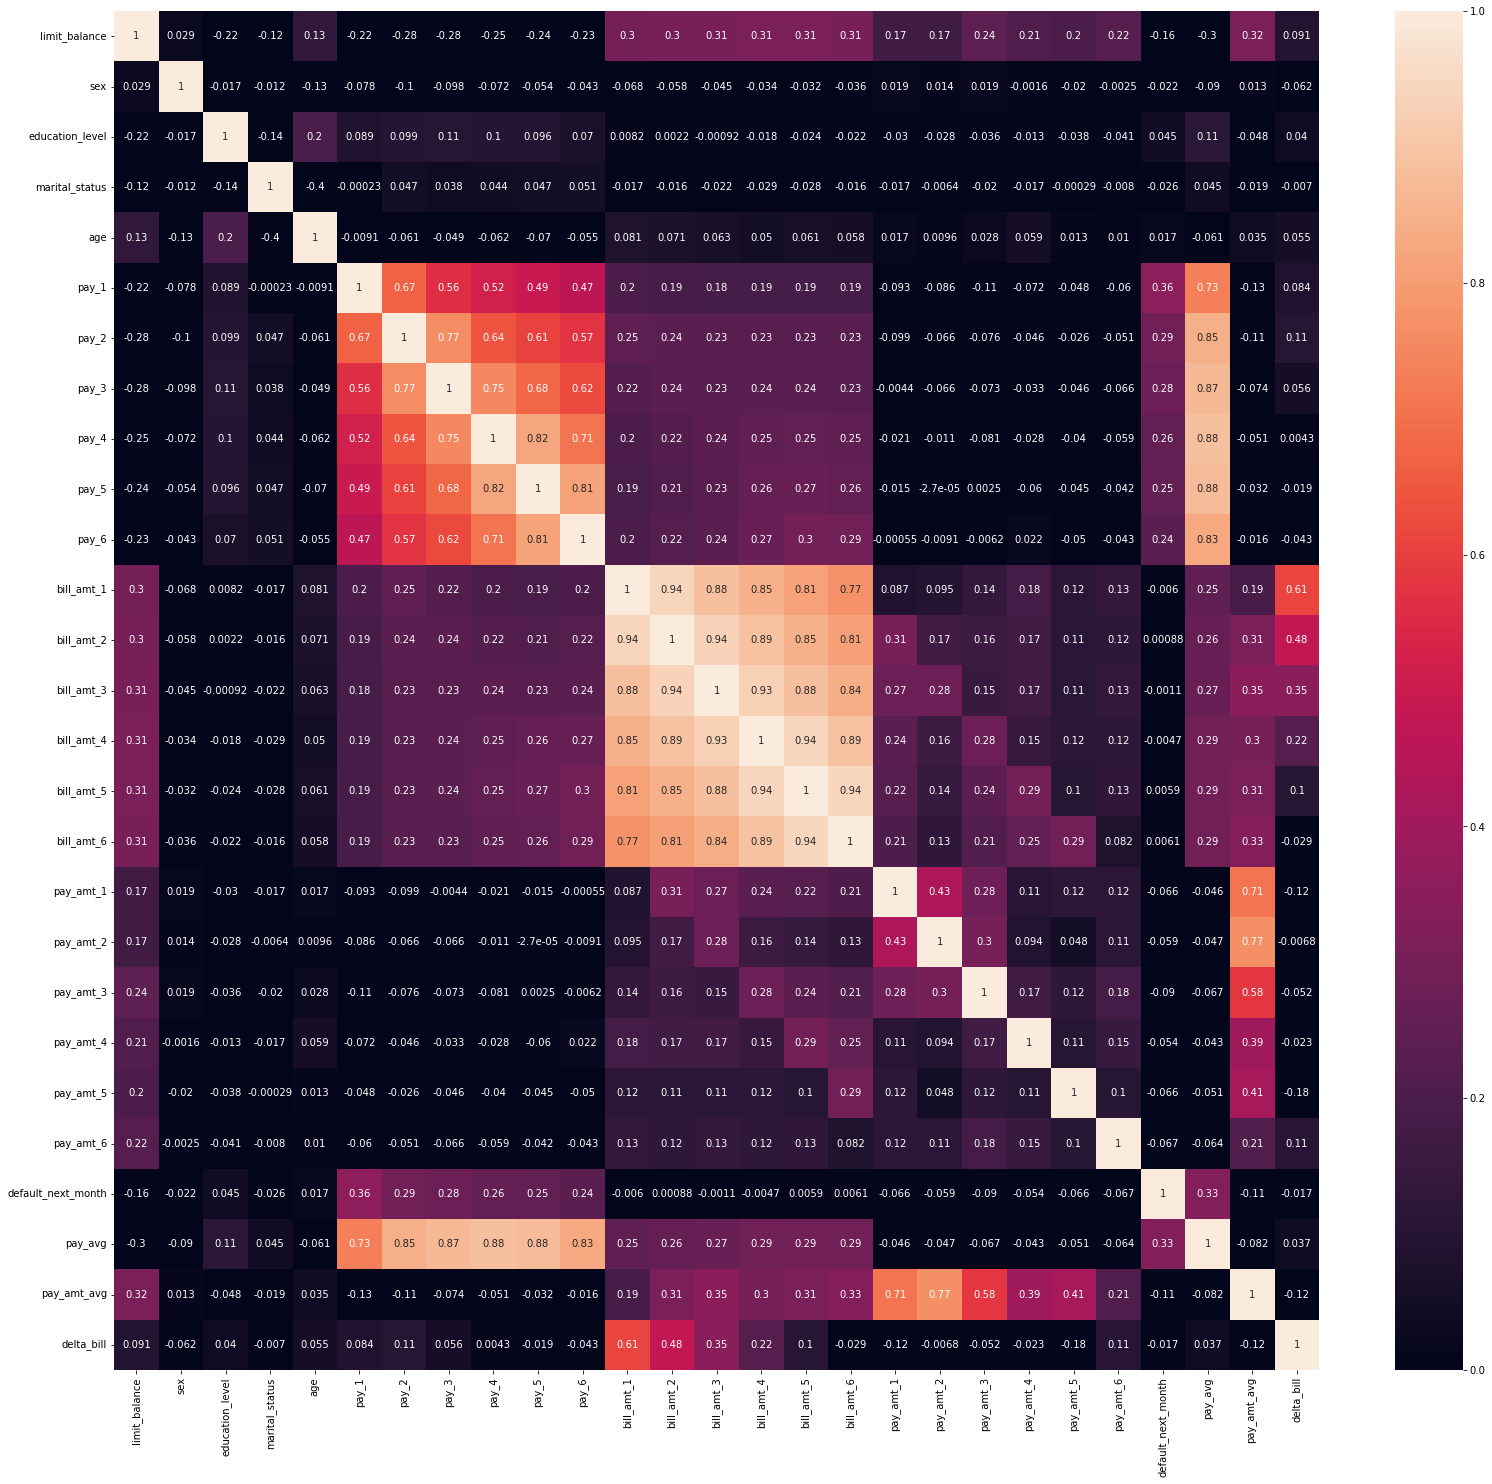

In [15]:
corr = df_credit.corr()

plt.figure(figsize=(27, 25))
sns.heatmap(corr, annot= True, vmin=0, vmax=1)
plt.show()

dari tabel heatmap korelasi antar fitur, dapat terlihat banyak korelasi yang tinggi untuk kolom `pay`, `bill_amt` dan `pay_amt`, dikarenakan kolom tersebut adalah urutan yang saling berkaitan dalam pelunasan hutang setiap bulannya. 

`pay_1` adalah kolom yang memiliki korelasi positif paling berpengaruh dalam menentukan label **default next month**

pada `pay_amt_avg` atau rata-rata pelunasan hutang dapat terlihat korelasi negatif untuk penentuan klasifikasi **default next month**

## Perbandingan Antar Target

dilkakukan filtering data pada kedua target

In [16]:
# data target default 0
dnm_0 = df_credit.query("default_next_month == 0")
# data target default 1
dnm_1 =  df_credit.query("default_next_month == 1")

membuat **plot** dengan **perbandingan** bagaimana **kebiasaan debitur** kebanyakan sesuai dengan **nilai target** melakukan pelunasan setiap bulannya dengan 

c:\Users\ajies\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\ajies\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\Users\ajies\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\ajies\anaconda3\lib\site-pack

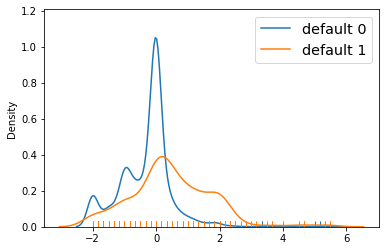

In [17]:


g = sns.distplot(dnm_0[['pay_avg']],label="default 0", hist=False, rug=True)
g = sns.distplot(dnm_1[['pay_avg']],label="default 1", hist=False, rug=True)
# plt.setp(g._legend().get_texts(), fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='40')
plt.show()

pada plot diatas, debitur dengan status masih mampu membayar hutang atau **default 0** kebanyakan **tepat waktu** namun **belum lunas** , sedangkan mereka yang **default 1** lebih sering terlambat membayar **1-2 bulan**

## Categories

data exploration on categorical data

### Marital Status

status pernikahan tidak terlihat ada hubungan dengan `default_next_month credit`, akan tetapi secara jumlah , pada `marital_status` **2 (sudah menikah)** paling sering melakukan pinjaman

<AxesSubplot:xlabel='count', ylabel='marital_status'>

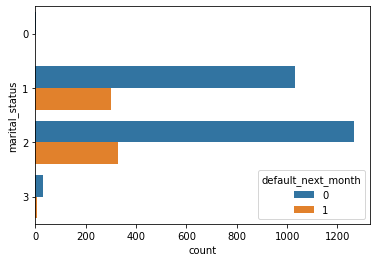

In [18]:

sns.countplot(data=df_credit,y='marital_status',hue='default_next_month')

### Gender

sekilas laki-laki dan wanita **tidak ada hubungannya** dengan **default_next_month kredit**, keduanya memiliki rasio gagal membayar yang hampir sama

<AxesSubplot:xlabel='count', ylabel='sex'>

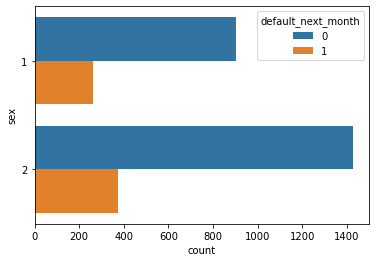

In [19]:

sns.countplot(data=df_credit,y='sex',hue='default_next_month')

### Education

jika ditinjau dari pendidikannya, frekuensi melakukan pinjaman **mulai banyak** dari pendidikan level 3 **(High school)**, 

dan **paling banyak** pada level 2 **(undergraduate)**

akan tetapi tidak ada pola tertentu pada rasio gagal membayar pinjaman atau `default_next_month`

<AxesSubplot:xlabel='count', ylabel='education_level'>

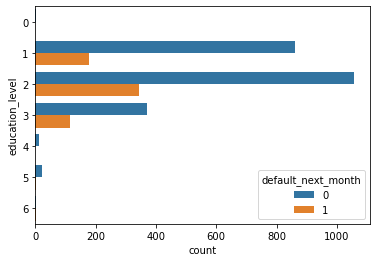

In [20]:
sns.countplot(data=df_credit,y='education_level',hue='default_next_month')

### Pay (Status Pembayaran)

Jika dilihat dari status pembayaran pinjaman, yang **tergolong** default(gagal membayar) mulai **lebih banyak** pada menunggak pembayaran **lebih dari 2 bulan**

dari semua status pembayaran setiap bulan, semua nya memiliki result yang sama, hanya saja pada `pay_2` atau status pembayaran bulan agustus, tidak ada yang menunggak satu bulan, akan tetapi langsung 2 bulan

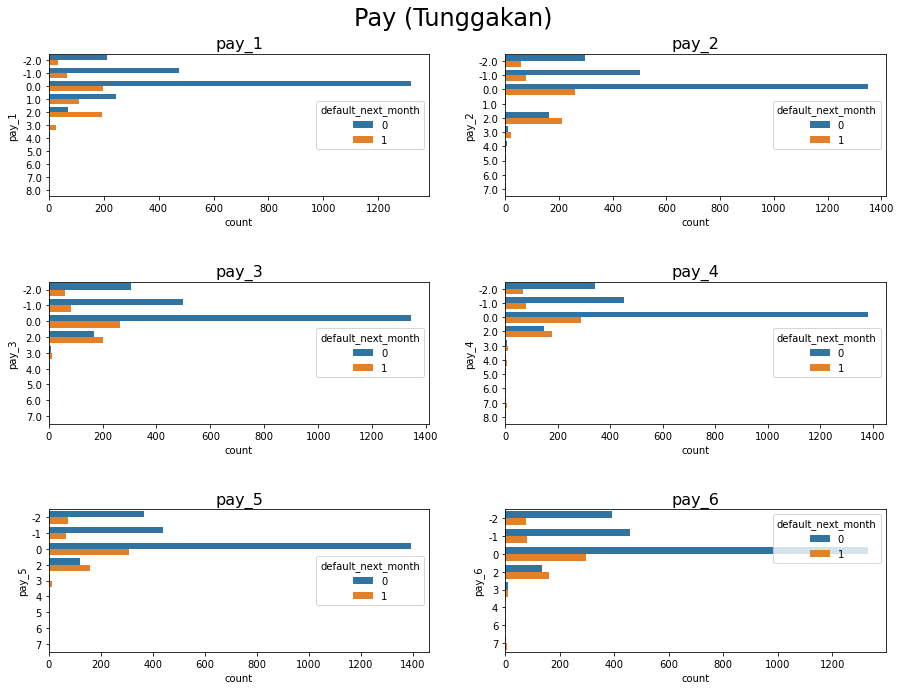

In [21]:
fig,ax = plt.subplots(3,2,figsize=(15,11))
fig.suptitle("Pay (Tunggakan)",fontsize=24, y=.94)
fig.subplots_adjust(top=.88)
fig.subplots_adjust(hspace=.6)

col = 0
row = 0

for value in range(6):
    if value != value:
        continue
    str_idx = str(value+1)

    sns.countplot(data=df_credit,y='pay_'+str_idx,hue='default_next_month',ax=ax[row,col])
    ax[row,col].set_title('pay_'+str_idx,fontsize= 16)
    
    if col > 0:
        col = 0
        row += 1
    else:
        col +=1

## Rata-Rata pada status Pelunasan Pinjaman

Selama ini status pelunasan tiap bulan merupakan feature yang paling ber korelasi dengan target

<AxesSubplot:ylabel='pay_avg'>

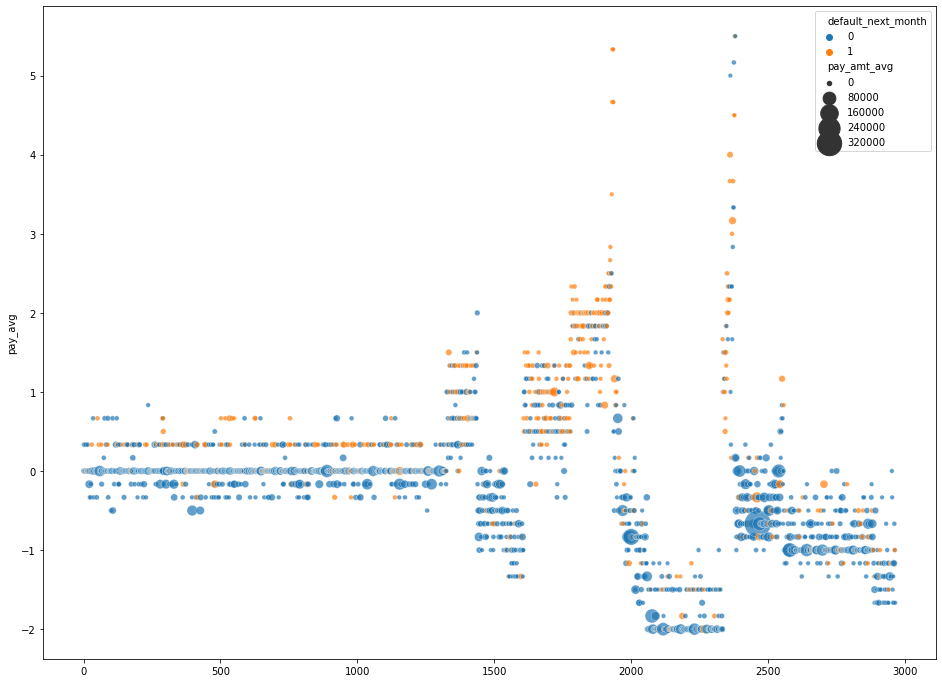

In [22]:
rcParams['figure.figsize'] = 16,12
sns.scatterplot(data=df_credit,y='pay_avg',x=df_credit.index,hue='default_next_month',size='pay_amt_avg',sizes=(20,700),alpha=0.7)

dapat terlihat kebanyakan debitur dengan status **default bulan depan** ada pada status **pelunasan** yang tinggi **(sering telat bayar)**, dan rata-rata pembayarannya lebih kecil. Sedangkan debitur dengan status **pelunasan yang rendah** lebih cenderung memiliki **status 0** pada default bulan depan.

jika dipilih pada datapoint pada rata-rata status pelunasan terlambat lebih dari 1 bulan, maka kategori target **didominasi** oleh debitur dengan status **default pada bulan depan**

<AxesSubplot:ylabel='pay_avg'>

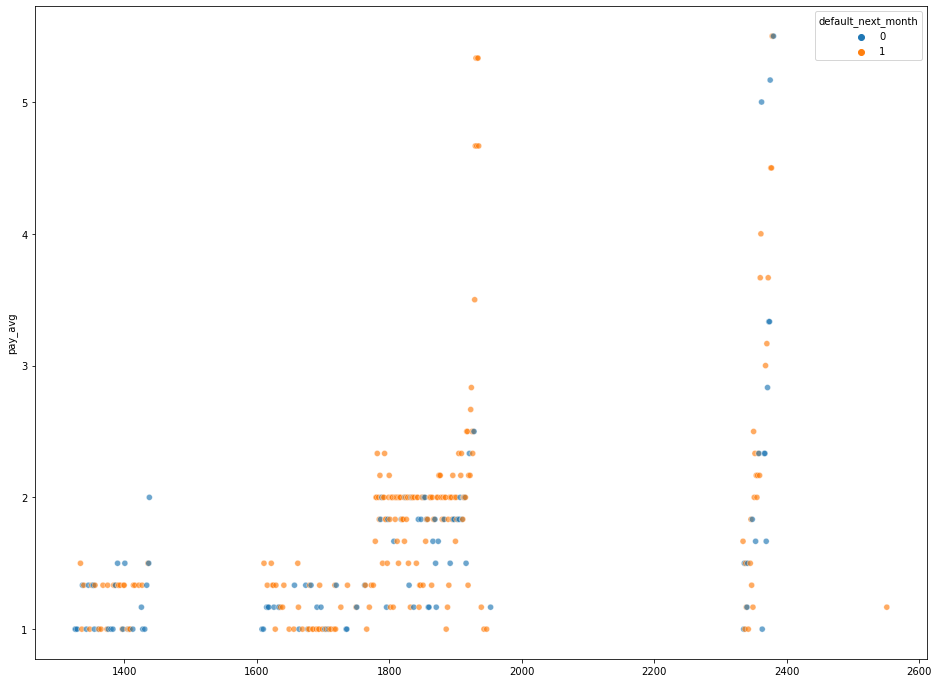

In [23]:
pay_1 = df_credit.query("pay_avg >= 1")
sns.scatterplot(data=pay_1,y='pay_avg',x=pay_1.index, hue='default_next_month',alpha=0.65)

# V. Data Preprocessing

- pilih **inference data**
- pilih **non inference** data untuk dijadikan data training dan test


## Inference & Non-Inference

**Set Data Inference**

In [24]:
# take 12 sample of random data
pickup_inf = df_credit.sample(10,random_state=12)

pickup_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 2410 to 2627
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   limit_balance       10 non-null     float64
 1   sex                 10 non-null     int64  
 2   education_level     10 non-null     int64  
 3   marital_status      10 non-null     int64  
 4   age                 10 non-null     float64
 5   pay_1               10 non-null     float64
 6   pay_2               10 non-null     float64
 7   pay_3               10 non-null     float64
 8   pay_4               10 non-null     float64
 9   pay_5               10 non-null     int64  
 10  pay_6               10 non-null     int64  
 11  bill_amt_1          10 non-null     float64
 12  bill_amt_2          10 non-null     float64
 13  bill_amt_3          10 non-null     float64
 14  bill_amt_4          10 non-null     float64
 15  bill_amt_5          10 non-null     float64
 16  bill_

**Set Non-Inference**

In [25]:
# REMOVE INFERENCE SET FROM DATA SET for non inference data
non_inference = df_credit.drop(pickup_inf.index)
non_inference.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2955 entries, 0 to 2964
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   limit_balance       2955 non-null   float64
 1   sex                 2955 non-null   int64  
 2   education_level     2955 non-null   int64  
 3   marital_status      2955 non-null   int64  
 4   age                 2955 non-null   float64
 5   pay_1               2955 non-null   float64
 6   pay_2               2955 non-null   float64
 7   pay_3               2955 non-null   float64
 8   pay_4               2955 non-null   float64
 9   pay_5               2955 non-null   int64  
 10  pay_6               2955 non-null   int64  
 11  bill_amt_1          2955 non-null   float64
 12  bill_amt_2          2955 non-null   float64
 13  bill_amt_3          2955 non-null   float64
 14  bill_amt_4          2955 non-null   float64
 15  bill_amt_5          2955 non-null   float64
 16  bill_a

In [26]:
# reset index for safety measure
non_inference.reset_index(drop=True,inplace=True)


## Feature & Target

Pilih **X(Features)** dan **y(Target)** menggunakan tabel **Non-Inference data**

Gunakan `train_test_split` dari library **scikitlearn**
- 20% baris dari `non_inference` akan digunakan untuk test

In [27]:
feature = non_inference.drop('default_next_month',axis=1)
target = non_inference['default_next_month']
target

0       0
1       0
2       0
3       0
4       0
       ..
2950    0
2951    0
2952    0
2953    1
2954    0
Name: default_next_month, Length: 2955, dtype: int64

In [28]:
feature.head()

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,pay_avg,pay_amt_avg,delta_bill
0,50000.0,1,1,2,39.0,0.0,0.0,0.0,0.0,0,0,47174.0,47974.0,48630.0,50803.0,30789.0,15874.0,1800.0,2000.0,3000.0,2000.0,2000.0,2000.0,0.000000,2160.0,6260.0
1,110000.0,2,1,2,29.0,0.0,0.0,0.0,0.0,0,0,48088.0,45980.0,44231.0,32489.0,26354.0,20221.0,2000.0,2010.0,3000.0,3000.0,3000.0,1000.0,0.000000,2602.0,5573.4
2,270000.0,1,1,2,36.0,0.0,0.0,0.0,2.0,0,0,78630.0,68921.0,46512.0,40335.0,37165.0,22156.0,10076.0,4018.0,14.0,2051.0,2000.0,0.0,0.333333,3631.8,11294.8
3,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0.000000,2528.6,-1383.8
4,50000.0,1,1,2,24.0,0.0,0.0,0.0,0.0,0,0,42058.0,35340.0,22110.0,19837.0,19855.0,20151.0,1367.0,1606.0,692.0,709.0,721.0,692.0,0.000000,1019.0,4381.4


## Split Train dan Test

In [29]:
# set test_size=0.2 to set 20% test data
x_train, x_test,y_train,y_test = train_test_split(feature,target,test_size=0.2,random_state=20) 

print("x_train",x_train.shape)
print("y_train",y_train.shape)

x_train (2364, 26)
y_train (2364,)


## Feature Selection

**Decision Tree Classifier** untuk membantu menentukan **seleksi feature**, karena pada Tree Classifier terdapat output **Importance Value**

### Seleksi Fitur Decision Tree

In [30]:
x_train.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'pay_avg', 'pay_amt_avg', 'delta_bill'],
      dtype='object')

pilih feature numerik dan kategori

In [31]:
selectList = ['limit_balance','age', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6','pay_avg', 'pay_amt_avg',
       'delta_bill']

selectUnscale= [ 'sex', 'education_level', 'marital_status',
                'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', ]

In [32]:
scaler = MinMaxScaler() 
scaler.fit(x_train) # mesin Belajar menggunakan data train (mesin harus belajar mana xmax dan xmin tiap column)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Kode dijalankan jika kategori tidak ingin di scale

In [33]:
# unscale_train = x_train[selectUnscale].to_numpy()
# unscale_test = x_test[selectUnscale].to_numpy()


In [34]:
# selection_train_final = np.concatenate([unscale_train,x_train_scaled],axis=1)
# selection_test_final = np.concatenate([unscale_test,x_test_scaled],axis=1)

###  **Decision Tree** model

In [35]:
seslection_model = DecisionTreeClassifier()

In [36]:
seslection_model.fit(x_train_scaled,y_train)

DecisionTreeClassifier()

In [37]:
selection_pred = seslection_model.predict(x_train_scaled)

#### Pruning

untuk melihat **perbedaan** yang **sebelum** prunning dan yang **sesudah** prunning

definisikan list aplha untuk mencari prunning yang menhasilkan best fit

In [38]:
path=seslection_model.cost_complexity_pruning_path(x_train_scaled,y_train)
alphas = path['ccp_alphas']
alphas

array([0.        , 0.00027922, 0.00028201, 0.00033841, 0.00033841,
       0.00036258, 0.00036258, 0.00038071, 0.00038456, 0.0003928 ,
       0.00039481, 0.00039481, 0.00039813, 0.00039884, 0.00039951,
       0.00040186, 0.00040349, 0.00040378, 0.00040609, 0.00040891,
       0.00041019, 0.00041202, 0.00041472, 0.00041729, 0.00041779,
       0.00041809, 0.0004192 , 0.00042301, 0.00042301, 0.00042301,
       0.00042301, 0.0004351 , 0.00044224, 0.00046042, 0.00048344,
       0.0004883 , 0.00049177, 0.00050427, 0.00050761, 0.00052596,
       0.00053505, 0.00054374, 0.00054387, 0.00055553, 0.00056402,
       0.00056402, 0.00056402, 0.00056402, 0.00056402, 0.00056402,
       0.00056402, 0.00056402, 0.00056402, 0.00056402, 0.00056402,
       0.00061326, 0.00061332, 0.00062042, 0.00062159, 0.00063452,
       0.00063452, 0.00063452, 0.00063452, 0.00063452, 0.00064459,
       0.0006578 , 0.00067466, 0.00067682, 0.00067682, 0.00067682,
       0.00067682, 0.00067682, 0.00067682, 0.00067682, 0.00068

nanti akan dibandingkan hasil sebelum pruning dan setelah pruning

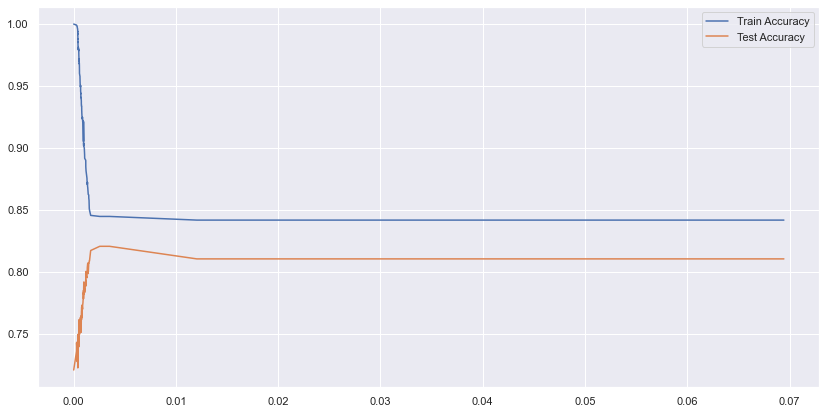

In [39]:
accuracy_train,accuracy_test=[],[]

for i in alphas :
    seslect_model = DecisionTreeClassifier(criterion="gini",ccp_alpha=i)

    seslect_model.fit(x_train_scaled,y_train)
    y_train_pred = seslect_model.predict(x_train_scaled)
    y_test_pred = seslect_model.predict(x_test_scaled)

    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=alphas, label='Train Accuracy')
sns.lineplot(y=accuracy_test,x=alphas, label='Test Accuracy')
#plt.xticks(ticks=np.arrange(0.00,0.25,0.01))
plt.show()

hasil dari deretan  pruning, alpha **dipilih** salah satu antara dari 0 hingga 0.004 yaitu **0.003**

In [40]:
seslection_model_2 = DecisionTreeClassifier(criterion="gini",ccp_alpha=0.003) # digunakan alpha terpilih o.oo3

seslection_model_2.fit(x_train_scaled,y_train)
y_train_pred = seslection_model_2.predict(x_train_scaled)

In [41]:
y_test_pred = seslection_model_2.predict(x_test_scaled)

In [42]:
print("test acc : ",accuracy_score(y_test,y_test_pred))
print("train acc : ",accuracy_score(y_train,y_train_pred))

test acc :  0.8206429780033841
train acc :  0.8447546531302876


In [43]:
seslection_model.feature_importances_

array([0.06464078, 0.01237572, 0.01147792, 0.00660151, 0.07645418,
       0.21401905, 0.0062172 , 0.00253278, 0.00106598, 0.00967147,
       0.01483184, 0.01902334, 0.04037631, 0.04637969, 0.0268772 ,
       0.04231382, 0.02977188, 0.0223718 , 0.04763365, 0.03157943,
       0.03011697, 0.04060885, 0.05571486, 0.06233255, 0.04050933,
       0.04450187])

buat **dataframe** untuk hasil dari fearture importance

In [44]:
df_importance = pd.DataFrame([seslection_model.feature_importances_,seslection_model_2.feature_importances_],
                   columns=['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'pay_avg', 'pay_amt_avg', 'delta_bill'])

#### Hasil Seleksi Fitur Decision Tree

In [45]:
df_importance

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,pay_avg,pay_amt_avg,delta_bill
0,0.064641,0.012376,0.011478,0.006602,0.076454,0.214019,0.006217,0.002533,0.001066,0.009671,0.014832,0.019023,0.040376,0.04638,0.026877,0.042314,0.029772,0.022372,0.047634,0.031579,0.030117,0.040609,0.055715,0.062333,0.040509,0.044502
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.817122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182878,0.000000,0.000000


terlihat data pada **baris 0** adalah yang sebelum dilakukan **prunning**, sedangkan pada **baris 1** adalah yang telah di **prunning**

### Pilih Feature

Dari Proses **EDA** and **Decision Tree** *Importance Value*, dipilih feature : `pay_1`, `pay_avg`,`pay_amt_avg`.

Pada `pay_1`, `pay_avg` memiliki nilai decision tree importance yang cukup besar.

Namun pada `pay_amt_avg`, terdapat nilai yang lebih besar pada **target 0**

In [46]:

selected_cols = ['pay_1', 'pay_avg','pay_amt_avg']

In [47]:
x_train = x_train[selected_cols]

In [48]:
x_test = x_test[selected_cols]

## Missing Value
**Check** jika feature memiliki **Missing Value**

Check missing value pada **X test**

In [49]:
x_train.isnull().sum()

pay_1          0
pay_avg        0
pay_amt_avg    0
dtype: int64

Check missing value pada **X test**

In [50]:
x_test.isnull().sum()

pay_1          0
pay_avg        0
pay_amt_avg    0
dtype: int64

Check missing value pada `y_test`

In [51]:
print(y_test.isnull().sum())

0


Check missing value pada `y_train`

In [52]:
print(y_train.isnull().sum())

0


this selected columns has no missing value on neither training or test  data

## Bagi Antara Numerik and Kategori

definisikan kolom `pay_1` menjadi kategori

In [53]:
# change numerical categories on train data
x_train['pay_1'] = x_train['pay_1'].apply(str)
x_test['pay_1'] = x_test['pay_1'].apply(str)

In [54]:
# split between numeric and categorical with 'include' data type
num_columns = x_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = x_train.select_dtypes(include=['object']).columns.tolist()

print('Numeric Columns:',num_columns)
print('Category Columns:',cat_columns)

Numeric Columns: ['pay_avg', 'pay_amt_avg']
Category Columns: ['pay_1']


In [55]:
# split train_set and test_set based on col type

x_train_num = x_train[num_columns]
x_train_cat = x_train[cat_columns]

x_test_num = x_test[num_columns]
x_test_cat = x_test[cat_columns]

## Outliers
Handling Outliers karena akan menggunakan model **SVM ,Logistic Regression ,dan KNN**

### Distribusi Feature

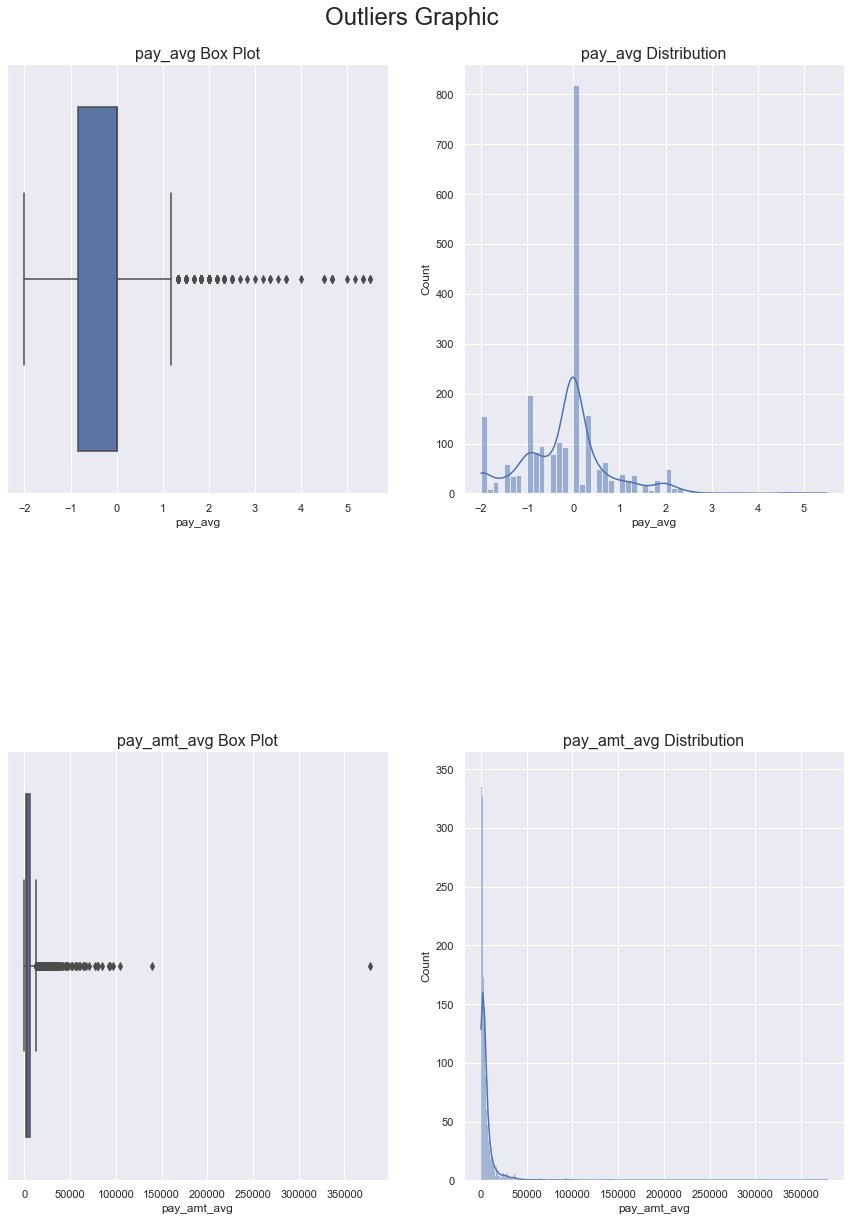

In [56]:
outlier_graph(x_train_num)

pada kolom `pay_amt_avg` terdapat skewness yang terlalu extreme, kemungkinan akan menggunakan batas **IQR** 0.05,0.95 atau 0.01,0.99

### Jumlah outlier

In [57]:
col_skews = skewness(x_train_num)

In [58]:
outliers = outliersCheck(x_train_num,col_skews)


feature name :  pay_avg
outliers percentage : 8.0%
distribution right_skew
upper : 1.25 lower : -2.0833333333333335
****************************************************
feature name :  pay_amt_avg
outliers percentage : 2.2%
distribution right_skew_ext
upper : 34471.559999999976 lower : -13228.949999999999
****************************************************


- terdapat 2.2% outlier pada `pat_amt_avg`
- 8% pada `pay_avg`

### Censoring Nilai Outlier 

**Censor** atau **Capping** dilakukan dengan menggunakan library `Winsorizer`

In [59]:
# outliers use quantile 0.05 and 0.95 to handle the capital gain
x_train_clean = censoring_outliers(x_train_num,outliers,0.05)

jika check kembali, outlier sudah hilang

In [60]:
col_skews = skewness(x_train_clean)
outliers = outliersCheck(x_train_clean,col_skews)

feature name :  pay_avg
outliers percentage : 0.0%
distribution left_skew_ext
upper : 2.5416666666666665 lower : -4.5
****************************************************
feature name :  pay_amt_avg
outliers percentage : 0.0%
distribution right_skew_ext
upper : 34442.66849999996 lower : -13228.949999999999
****************************************************


lihat **perubahan** setelah outlier ditangani

In [61]:
print(x_train_num.describe().T)
print(x_train_clean.describe().T)
x_train_clean.shape

              count         mean           std  min          25%     50%  \
pay_avg      2364.0    -0.151720      0.995753 -2.0    -0.833333     0.0   
pay_amt_avg  2364.0  5601.995093  12424.085325  0.0  1162.250000  2465.2   

                75%       max  
pay_avg         0.0       5.5  
pay_amt_avg  5571.9  378353.2  
              count         mean          std  min          25%     50%  \
pay_avg      2364.0    -0.398354     0.623382 -2.0    -0.833333     0.0   
pay_amt_avg  2364.0  4554.681891  5406.868408  0.0  1162.250000  2465.2   

                75%           max  
pay_avg         0.0      0.041667  
pay_amt_avg  5571.9  21242.610000  


(2364, 2)

Nilai Maksimal pada setiap kolom berubah dan rata-rata nilai sedikit berubah

In [62]:

x_train_num = x_train_clean

## Feature Scalling
Feature Scalling untuk Data Numerik

In [63]:
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                             MinMaxScaler())

## Feature Encoding

feature encoding only for category data, later will split nominal and ordinal data for different encoding treatment 

In [64]:
x_train_cat.columns

Index(['pay_1'], dtype='object')

In [65]:

# make ordered unique value of education_num
list_ordinal_pay1 = list(x_train_cat['pay_1'].unique())
list_ordinal_pay1.sort(key=float)
list_ordinal_pay1


['-2.0', '-1.0', '0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0']

karena data kategori terdapat sebuah urutan, maka menggunakan **ordinal encoder**

In [66]:
cat_pipeline = make_pipeline(OrdinalEncoder(categories=[list_ordinal_pay1]))

In [67]:
print('Numeric Columns:',num_columns)
print('Category Columns:',cat_columns)

Numeric Columns: ['pay_avg', 'pay_amt_avg']
Category Columns: ['pay_1']


## Gabungkan Data Numerik and Kategori

In [68]:
preprocess_pipeline = ColumnTransformer([
    ('pipeline_numerik', num_pipeline, num_columns),
    ('pipeline_kategori', cat_pipeline, cat_columns)
])

# VI. Model Definition

model untuk prediksi target , menggunakan pendekatan machinelearning supervised dengan 7 algoritma yang klasifikasi yang berbeda

## Logistic Regression

- **tanpa hyperparameter**

In [69]:
# Training Logistic Regression
logreg_pipe = make_pipeline(preprocess_pipeline, LogisticRegression())

## SVM

- **tanpa hyperparameter**

In [70]:
# Model SVM Classivication
svc_pipe = make_pipeline(preprocess_pipeline, SVC())

## Decision Tree

- **tanpa hyperparameter**

In [71]:
tree_pipe = make_pipeline(preprocess_pipeline, DecisionTreeClassifier())

## Random Forest

- **tanpa hyperparameter**

In [72]:
forest_pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier())

## KNN

- **tanpa hyperparameter**

In [73]:
knn_pipe = make_pipeline(preprocess_pipeline, KNeighborsClassifier())

## Naive Bayes

- **tanpa hyperparameter**

In [74]:
nb_pipe = make_pipeline(preprocess_pipeline, GaussianNB())

## XGBoost 

- **tanpa hyperparameter**

In [75]:
xgb_pipe = make_pipeline(preprocess_pipeline, XGBClassifier())

## Best Model

In [76]:
# Membuat data frame untuk hasil 
dict_model = {'logistic_regression':logreg_pipe,'svc':svc_pipe,'decission_tree':tree_pipe,
              'random_forest':forest_pipe,'knn':knn_pipe,'xgboost':xgb_pipe}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#list penampung hasil validasi silang
list_mean = [] # untuk rata-rata hasil
list_std = [] # untuk standard deviasi
list_sum = [] # standard deviasi + rata-rata
list_delta = [] # rata-rata - standard deviasi
list_nama_model = [] # penampung untuk nama kolom

for key,model in dict_model.items():
    # validasi silang
    scores = cross_val_score(model, x_train, y_train, cv=cv)

    # masukan nilai rata rata dan standard deviasi
    list_mean.append(scores.mean())
    list_std.append(scores.std())
    list_sum.append(scores.mean()+scores.std())
    list_delta.append(scores.mean()-scores.std())
    list_nama_model.append(key)
    
    # buat dataframe dari list penampung hasil validasi silang
df_result = pd.DataFrame(np.array([list_mean, list_std, list_sum, list_delta]),
                         columns=list_nama_model,
                         index=['mean','std','sum','delta'])

df_result.T.sort_values('delta')


,mean,std,sum,delta
decission_tree,0.757748,0.021238,0.778986,0.736510
random_forest,0.774821,0.022383,0.797204,0.752439
knn,0.825875,0.019432,0.845307,0.806444
xgboost,0.833618,0.016265,0.849882,0.817353
logistic_regression,0.837007,0.017786,0.854794,0.819221
svc,0.841807,0.018035,0.859842,0.823771


mungkin **SVC** secara akurasi sedikit lebih unggul dari **XGBoost**, tetapi saya akan memilih **XGBoost** karena nilai standard deviasi yang lebih kecil, karenakan juga batasan laptop yang kurang memumpuni untuk ber -eksperimen dengan hyperparameter tuning.

## XGBoost Search Grid

In [77]:
param_test = {'xgbclassifier__nthread':[4], #when use hyperthread, xgboost may become slower
            'xgbclassifier__n_estimators': [70,700], # kurangi untuk mengurangi dampak overfit
            'xgbclassifier__colsample_bytree': [0.7],
            'xgbclassifier__max_depth': [2], # untuk pruning
            'xgbclassifier__num_leaves': [10],
            'xgbclassifier__min_child_weight' :[100,250], # mengurangi overvitting
            'xgbclassifier__min_split_gain': [0.3],
            'xgbclassifier__seed': [37]} # membuat seed random number

gs_xg = GridSearchCV(xgb_pipe, param_grid=param_test, cv=5, scoring="accuracy")

# VII. Model Training

training hanya pada model terbaik yaitu **XGBoost**

In [78]:

xgb_pipe.fit(x_train,y_train)
gs_xg.fit(x_train,y_train)

[07:48:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_split_gain", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:48:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_split_gain", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:48:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_split

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline_numerik',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['pay_avg',
                                                                          'pay_amt_avg']),
                                                                        ('pipeline_kategori',
                                                                         Pipeline(steps=[('ordinalencoder',
  

In [79]:
gs_xg.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline_numerik',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['pay_avg', 'pay_amt_avg']),
                                                 ('pipeline_kategori',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['-2.0',
                                                                                               '-1.0',
                                                                                               '

# VIII. Model Evaluation

**Model Terpilih -XGBoost-**

Gunakan **Confusion Matrix** dan **Classification Report**  Untuk Evaluasi Model



In [80]:
#definisi fungsi untuk membantu menampilkan confusion matrix dan laporan klasifikasi
def show_evaluation(y,pred,model):
    
    cm = confusion_matrix(y, pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y,pred))

prediksi dengan data train dan test

In [81]:
y_train_pred_plain=xgb_pipe.predict(x_train)
y_test_pred_plain=xgb_pipe.predict(x_test)

x_train_pred_gs = gs_xg.best_estimator_.predict(x_train)
x_test_pred_gs = gs_xg.best_estimator_.predict(x_test)

### Tanpa Hyperparameter

Hasil Dari base model **tanpa hyperparameter** lebih menuju **overfit** atau hasil akurasi test lebih bagus daripada test

In [82]:
print("Akurasi Train : ",accuracy_score(y_train,y_train_pred_plain))
print("Akurasi Test : ",accuracy_score(y_test,y_test_pred_plain))

Akurasi Train :  0.8976311336717429
Akurasi Test :  0.805414551607445


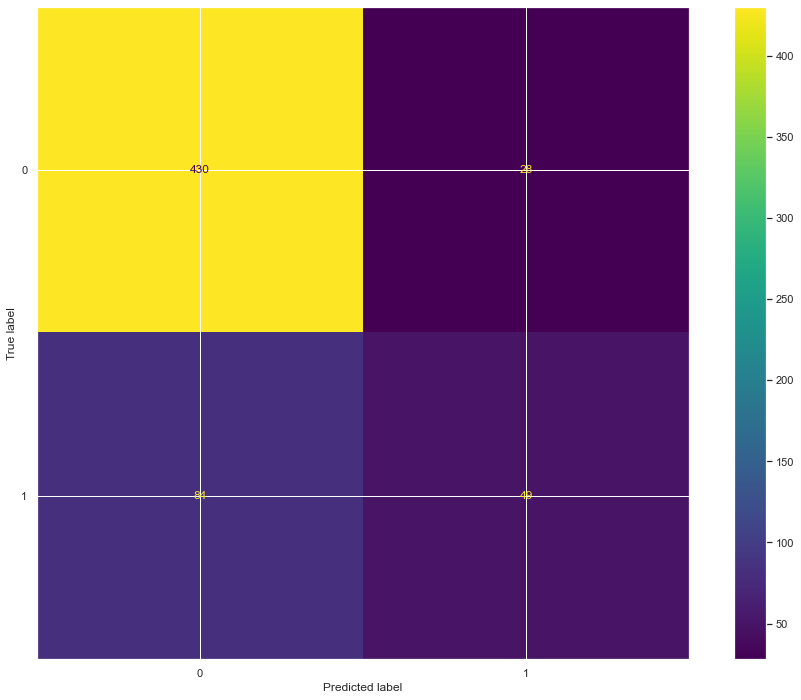

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       458
           1       0.64      0.37      0.47       133

    accuracy                           0.81       591
   macro avg       0.74      0.65      0.68       591
weighted avg       0.79      0.81      0.79       591



In [83]:
show_evaluation(y_test,x_test_pred_gs,xgb_pipe)

### Dengan Hyper Parameter

hasil pada evaluasi dengan hyperparameter terbaik

In [84]:
print("Akurasi Train : ",accuracy_score(y_train,x_train_pred_gs))
print("Akurasi Test : ",accuracy_score(y_test,x_test_pred_gs))

Akurasi Train :  0.8341793570219966
Akurasi Test :  0.8104906937394247


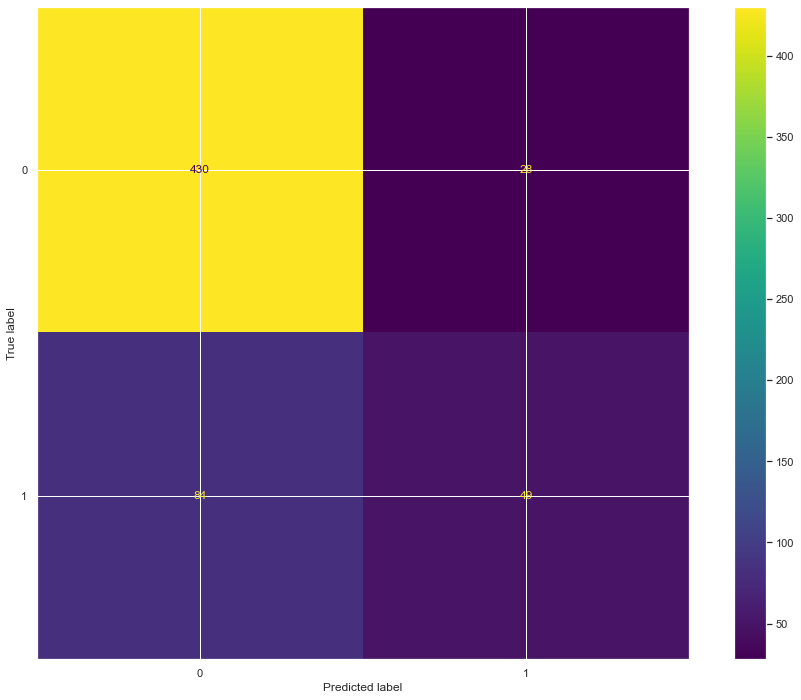

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       458
           1       0.64      0.37      0.47       133

    accuracy                           0.81       591
   macro avg       0.74      0.65      0.68       591
weighted avg       0.79      0.81      0.79       591



In [85]:
show_evaluation(y_test,x_test_pred_gs,gs_xg)

# IX. Model Inference

In [86]:
pickup_inf.reset_index(drop=True,inplace=True)

## Data Preprocessing

data preprocessing is cloned from the data training and test preprocessing

### Missing Value

data inference have no missing value

In [87]:
pickup_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   limit_balance       10 non-null     float64
 1   sex                 10 non-null     int64  
 2   education_level     10 non-null     int64  
 3   marital_status      10 non-null     int64  
 4   age                 10 non-null     float64
 5   pay_1               10 non-null     float64
 6   pay_2               10 non-null     float64
 7   pay_3               10 non-null     float64
 8   pay_4               10 non-null     float64
 9   pay_5               10 non-null     int64  
 10  pay_6               10 non-null     int64  
 11  bill_amt_1          10 non-null     float64
 12  bill_amt_2          10 non-null     float64
 13  bill_amt_3          10 non-null     float64
 14  bill_amt_4          10 non-null     float64
 15  bill_amt_5          10 non-null     float64
 16  bill_amt_6 

### Pilih Feature

In [88]:
selected_inf = pickup_inf[selected_cols]

jadikan kolom `pay_1` menjadi **string** 

In [89]:
selected_inf['pay_1'] = selected_inf['pay_1'].apply(str)

C:\Users\ajies\AppData\Local\Temp\ipykernel_3956\910780140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_inf['pay_1'] = selected_inf['pay_1'].apply(str)


In [90]:
selected_inf

,pay_1,pay_avg,pay_amt_avg
0,-1.0,-0.833333,16666.0
1,0.0,0.000000,17186.0
2,-1.0,-1.000000,2263.8
3,-2.0,-2.000000,6991.2
4,0.0,0.000000,3340.0
5,0.0,0.000000,2975.0
6,0.0,0.333333,1634.0
7,0.0,0.000000,2000.0
8,-1.0,-0.833333,379.2
9,-1.0,-1.000000,1108.8


### Prediksi Model Terbaik

In [91]:
inf_pred_gs = gs_xg.best_estimator_.predict(selected_inf)

## Membandingkan

### Prediksi  XGBoost

In [92]:
# dataframe for view (Tidak Wajib)

pred_inf_df = pd.DataFrame(inf_pred_gs,columns=['default_pred'])
pred_inf_df

,default_pred
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [93]:
# concate between inference set and
selected = selected_cols + ['default_next_month']

pred_df = pd.concat([pickup_inf[selected],pred_inf_df],axis=1)

pred_df

,pay_1,pay_avg,pay_amt_avg,default_next_month,default_pred
0,-1.0,-0.833333,16666.0,0,0
1,0.0,0.000000,17186.0,0,0
2,-1.0,-1.000000,2263.8,0,0
3,-2.0,-2.000000,6991.2,0,0
4,0.0,0.000000,3340.0,0,0
5,0.0,0.000000,2975.0,0,0
6,0.0,0.333333,1634.0,0,0
7,0.0,0.000000,2000.0,1,0
8,-1.0,-0.833333,379.2,0,0
9,-1.0,-1.000000,1108.8,0,0


# X. Kesimpulan

Dalam Project Milestone Pertama pada fase 1 ini, terdapat masalah , yaitu dari banya algoritma supervised learning klasifikasi, mana dari mereka cocok untuk jadi model prediksi untuk objektif pada milestone 1 ini, dimana objektifnya adalah membuat prediksi defaul_next_month atau status gagal bayar pada servis pinjaman.

untuk seleksi fitur sendiri telah dilakukan beberapa **EDA** dan seleksi fitur dari ***Decision Tree*** importance feature value.

hasil dari **EDA** terbagi dari bebrapa point, untuk menunjang pemilihan fitur yaitu 
- **pendidikan** , **gender**, dan **umur** **tidak berpengaruh** terhadap status target `(default_next_month)`.
- semakin **banyak menunggak** maka kemungkinan mendapat status **target 1**.
- kebanyakan debitur dengan status **target 0** membayar hutang mereka dengan **jumlah yang besar**.

memilih fitur dengan **decision tree** model. salah satu atribut output pada decision tree adalah feature importance, dimana dalam decision tree dapat mempertimbangkan fitur mana saja yang dipakai <br>
untuk memprediksi target, metode ini dipilih karena dalam presentasi [PyData DC 2016 Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ) nilai dari feature importance dapat menjadi pertimbangan memilih feature.

dari process **EDA** dan **Decision Tree** terpilihlah fitur yang akan digunakan yaitu `pay_1`, `pay_avg`, dan `pay_amt_avg`.

setelah dilakukan prerpocessing maka dilakukanlah pemodelan, dengan **beberapa model** yang nantinya **dipilih satu** yang **terbaik** menggunakan **cross validation** dan terpilihlah model **XGBoost** dengan akurasi 0.83 dan standart deviasi yang paling kecil

**XGBoost** kepanjangannya adalah *Extreme Gradient Boosting* dimana didalam gradient boost terdapat sekumpulan decision tree **sederhana** (Weak Learners) yang saling berhubungan dan menjadikannya **Strong Learner** <br>
lalu kenapa bernama **Gradient Boost** , jawabnya karena didalamnya terdapat algoritma **gradient descent** menurut [wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)

setelah **dievaluasi** XGBoost masih memiliki kecenderungan **overfitting**, kecenderungan ini karena DNA dari **Decision Tree** di dalam XGBoost itu sendiri, meskipun begitu pada **hyperparameter** ada beberapa **argumen** <br>
yang di design oleh developer nya untuk **mengurangi** dampak overfitting pada algoritma tersebut.

untuk masalah overfitting disini saya mencoba tuning beberapa parameter yaitu `min_child_weight`(tinnggi angka mengurangi overfit), `n_estimators`(semakin kecil angka mengurangi overfit tapi mengurangi akurasi), `max_depth` (semakin kecil semakin kurang akurasi tapi mengurangi dampak overfit) sesuait dengan panduan dokumnetasi [dokumentasi XGBoost](https://docs.getml.com/latest/api/getml.predictors.XGBoostClassifier.html)


# Pertanyaan Konseptual 

1. Apakah fungsi parameter `criterion` pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!
    -  Criterion adalah parameter dimana berfungsi untuk mengukur nilai pemisahan atribut pada decision tree
    dan terdapat 3 fungsi untuk mengukur nilai tersebut adalah `gini`, `entrophy`, dan `log_loss`
2. Apakah fungsi dari `pruning` pada Tree model?
    - **pruning** merupakan metode untuk **mengatasi overfitting** pada decision tree dengan cara **memotong** ranting atau **cabang** **atribut** pada decision tree, **dampaknya** dapat **menghilangkan nilai feature importance yang tidak signifikan** 
3. Bagaimana cara memilih `K` yang optimal pada KNN?
    - K merupakan jumlah tetangga terdekat, dimana algoritma model akan memilih data point sebagai acuan tetangga terdekat, banyak data point tersebut tergantung dengan jumlah nilai `K` 
    - untuk menghindari pemisahan klasifikasi yang 50:50 kita harus melihat berapa banyak jumlah klasifikasi pada target jika jumlah klasifikasi genap, masukan nilai `K` ganjil, jika klasifikasi berjumlah ganjil maka masukan nilai `K` genap
4. Jelaskan apa yang kalian ketahui tentang `Cross Validation`!
    - Cross Validation adalah metode evaluasi model machine learning dengan sampling train dan test yang merata sesuai dengan nilai lipatan atau `fold` dan partisi atau nilai `k`, atau pada library scikit-learn `cv`<br>
    apa yang dimaksud dengan merata? merata arti nya hampir semua baris data akan menjadi train dan test
5. Jelaskan apa yang kalian ketahui tentang `Accuracy, Precision, Recall, F1 Score`!
    - Accuracy adalah rasio dari keseluruhan ***true positif*** dan ***true negative*** dibandingkan jumlah baris data
    - Precision refrensi evaluasi jika ingin melihat banyak ***false positive*** diantara ***true positive***
    - Recall adalah refrensi  untuk melihat ***false negative*** diantara ***true positive***, biasa dipanggil dengan **TPR** atau *True Positive Rate*
    - F1 Score, adalah **rata-rata** pada nilai **presisi dan recall** dengan dihitung dengan **aritmatika harmonic**